In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np

# High number of transcripts caused by specific tissue or sample size

Reviewers were wondering why so many new transcripts (60%) <br>
"<br>
Moreover, it would be interesting to analyze, **whether the putatively novel transcripts are originating from specific datasets and/or tissues**. The link to the dataset(s) could be made available for unique tissue-transcript combinations.<br>
"<br>
"<br>
How would figure S2 look like if it were corrected by number of analysed tissues?<br>
"<br>


**IDEA:**

- check how the chosen cutoff changes how many new identified transcripts were found
- see if there exists a tissue where extraordinary many new transcripts were identified (ratio almost 1?)
- check if the ratio of new idetified transcripts correlated with the number of samples per tissue (spearman plot)

## Get the number of all and new transcripts below a specific threshold per tissue

**Data Cleaning:**

- Iterates through each sheet in the Excel file.
- Removes unnecessary columns, leaving only columns related to TPM mean values.
- Drops specific columns that are not required.
- Retains only columns related to TPM mean values, excluding columns with "Unnamed," "(sd)," and "(%)" in their names.
- Removes rows with missing values and retains only rows with transcript IDs starting with specific prefixes.

**Data Aggregation:**

- Initializes dictionaries to store the count of identified transcripts based on different TPM cutoffs for all transcripts and those specifically identified as NSTRG.
- For each sheet, iterates through the columns (tissues) and counts the number of transcripts that meet different TPM cutoffs (0.0001, 0.001, 0.01, 0.1, 1).
- Separately counts transcripts for NSTRG transcripts and updates the corresponding dictionaries.

**Dictionaries:**

- The code initializes dictionaries (dict_00001_all, dict_00001_NSTRG, etc.) to store the counts of identified transcripts based on different TPM cutoffs for all transcripts and NSTRG transcripts.
G transcripts.

In [301]:
#initiatlize three dicts with two different cutoffs (0.001,0.01,0.1,1) such as "dict_0001_all", "dict_001_all"

dict_00001_all ={}
dict_0001_all = {} # cutoff 0.001
dict_001_all = {} #cutoff 0.01
dict_01_all = {} #cutoff 0.1
dict_1_all = {} #cutoff 1 TPM

dict_00001_NSTRG = {}
dict_0001_NSTRG = {}
dict_001_NSTRG = {}
dict_01_NSTRG = {}
dict_1_NSTRG = {}

In [302]:
#import excel data
excel_file_path = 'Suppl_Table_S5_Transcripts_in_tissues.xlsx'

# iterate through each sheet
for sheet_name, sheet_df in all_sheets.items():
    if sheet_name == "Index":
        continue
    # if sheet_name != "ADGRV1": #just do it for the first sheet for testing cases
    #     continue 

    print("Go through aGPCR: ",sheet_name)

    #drop all unnessesary columns (we only need the TPM mean columns)
    sheed_cleaned = sheet_df.drop(columns=["gene_id","gene_name","length (bp)","start","end","# of exons"]) 
    columns_to_drop = ["number according to Figure 5", "Median", "Mean","number according to the Figure 1","number according to Figure 3"]
    # Iterate through the list and drop columns if they exist (they only exists in some of the sheets)
    for column in columns_to_drop:
        if column in sheed_cleaned.columns:
            sheed_cleaned.drop(column, axis=1, inplace=True)

    # only TMP(mean) needed 
    sheed_cleaned = sheed_cleaned.loc[:, ~(sheed_cleaned.columns.str.contains('Unnamed') | sheed_cleaned.columns.str.contains('(sd)') | sheed_cleaned.columns.str.contains('(%)'))]
    # drop columsn with NA and only rows with transcript
    sheed_cleaned = sheed_cleaned.dropna()
    prefixes_to_keep = ['NSTRG', 'XM', 'XR', 'XP','NM','NR']
    mask = sheed_cleaned['transcript_id'].str.startswith(tuple(prefixes_to_keep)).fillna(False)
    sheed_cleaned = sheed_cleaned[mask]

    tissues = sheed_cleaned.columns[1:]
    
    if not dict_0001_all:
        dict_00001_all = {column: 0 for column in tissues}
        dict_00001_NSTRG = {column: 0 for column in tissues}
        dict_0001_all = {column: 0 for column in tissues}
        dict_0001_NSTRG = {column: 0 for column in tissues}
        dict_001_all = {column: 0 for column in tissues}
        dict_001_NSTRG = {column: 0 for column in tissues}
        dict_01_all = {column: 0 for column in tissues}
        dict_01_NSTRG = {column: 0 for column in tissues}
        dict_1_all = {column: 0 for column in tissues}
        dict_1_NSTRG = {column: 0 for column in tissues}

    #get number of transcripts for all identified transcripts
    sheed_all = sheed_cleaned.drop('transcript_id', axis=1)
    for column in sheed_all.columns:
        count = sheed_all[column].apply(lambda x: 1 if x > 0.0001 else 0).sum()
        dict_00001_all[column] = dict_00001_all[column] + count
        count = sheed_all[column].apply(lambda x: 1 if x > 0.001 else 0).sum()
        dict_0001_all[column] = dict_0001_all[column] + count
        count = sheed_all[column].apply(lambda x: 1 if x > 0.01 else 0).sum()
        dict_001_all[column] = dict_001_all[column] + count
        count = sheed_all[column].apply(lambda x: 1 if x > 0.1 else 0).sum()
        dict_01_all[column] = dict_01_all[column] + count
        count = sheed_all[column].apply(lambda x: 1 if x > 1 else 0).sum()
        dict_1_all[column] = dict_1_all[column] + count

    # do the same for all NSTRG transcripts
    df_filtered = sheed_cleaned[sheed_cleaned["transcript_id"].astype(str).str.contains("NSTRG")]
    df_filtered = df_filtered.drop('transcript_id', axis=1)

    for column in df_filtered.columns:
        count = df_filtered[column].apply(lambda x: 1 if x > 0.0001 else 0).sum()
        dict_00001_NSTRG[column] = dict_00001_NSTRG[column] + count
        count = df_filtered[column].apply(lambda x: 1 if x > 0.001 else 0).sum()
        dict_0001_NSTRG[column] = dict_0001_NSTRG[column] + count
        count = df_filtered[column].apply(lambda x: 1 if x > 0.01 else 0).sum()
        dict_001_NSTRG[column] = dict_001_NSTRG[column] + count
        count = df_filtered[column].apply(lambda x: 1 if x > 0.1 else 0).sum()
        dict_01_NSTRG[column] = dict_01_NSTRG[column] + count
        count = df_filtered[column].apply(lambda x: 1 if x > 1 else 0).sum()
        dict_1_NSTRG[column] = dict_1_NSTRG[column] + count


Go through aGPCR:  ADGRA1
Go through aGPCR:  ADGRA2
Go through aGPCR:  ADGRA3
Go through aGPCR:  ADGRB1
Go through aGPCR:  ADGRB2
Go through aGPCR:  ADGRB3
Go through aGPCR:  ADGRC1
Go through aGPCR:  ADGRC2


/tmp/ipykernel_215457/2577562084.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sheed_cleaned = sheed_cleaned.loc[:, ~(sheed_cleaned.columns.str.contains('Unnamed') | sheed_cleaned.columns.str.contains('(sd)') | sheed_cleaned.columns.str.contains('(%)'))]
/tmp/ipykernel_215457/2577562084.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sheed_cleaned = sheed_cleaned.loc[:, ~(sheed_cleaned.columns.str.contains('Unnamed') | sheed_cleaned.columns.str.contains('(sd)') | sheed_cleaned.columns.str.contains('(%)'))]
/tmp/ipykernel_215457/2577562084.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sheed_cleaned = sheed_cleaned.loc[:, ~(sheed_cleaned.columns.str.contains('Unnamed') | sheed_cleaned.columns.str.contains('

Go through aGPCR:  ADGRC3
Go through aGPCR:  ADGRD1
Go through aGPCR:  ADGRD2
Go through aGPCR:  ADGRE1
Go through aGPCR:  ADGRE2
Go through aGPCR:  ADGRE3
Go through aGPCR:  ADGRE4P
Go through aGPCR:  ADGRE5


/tmp/ipykernel_215457/2577562084.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sheed_cleaned = sheed_cleaned.loc[:, ~(sheed_cleaned.columns.str.contains('Unnamed') | sheed_cleaned.columns.str.contains('(sd)') | sheed_cleaned.columns.str.contains('(%)'))]
/tmp/ipykernel_215457/2577562084.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sheed_cleaned = sheed_cleaned.loc[:, ~(sheed_cleaned.columns.str.contains('Unnamed') | sheed_cleaned.columns.str.contains('(sd)') | sheed_cleaned.columns.str.contains('(%)'))]
/tmp/ipykernel_215457/2577562084.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sheed_cleaned = sheed_cleaned.loc[:, ~(sheed_cleaned.columns.str.contains('Unnamed') | sheed_cleaned.columns.str.contains('

Go through aGPCR:  ADGRF1
Go through aGPCR:  ADGRF2
Go through aGPCR:  ADGRF3
Go through aGPCR:  ADGRF4
Go through aGPCR:  ADGRF5
Go through aGPCR:  ADGRG1
Go through aGPCR:  ADGRG2
Go through aGPCR:  ADGRG3
Go through aGPCR:  ADGRG4


/tmp/ipykernel_215457/2577562084.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sheed_cleaned = sheed_cleaned.loc[:, ~(sheed_cleaned.columns.str.contains('Unnamed') | sheed_cleaned.columns.str.contains('(sd)') | sheed_cleaned.columns.str.contains('(%)'))]
/tmp/ipykernel_215457/2577562084.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sheed_cleaned = sheed_cleaned.loc[:, ~(sheed_cleaned.columns.str.contains('Unnamed') | sheed_cleaned.columns.str.contains('(sd)') | sheed_cleaned.columns.str.contains('(%)'))]
/tmp/ipykernel_215457/2577562084.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sheed_cleaned = sheed_cleaned.loc[:, ~(sheed_cleaned.columns.str.contains('Unnamed') | sheed_cleaned.columns.str.contains('

Go through aGPCR:  ADGRG5
Go through aGPCR:  ADGRG6
Go through aGPCR:  ADGRG7
Go through aGPCR:  ADGRL1
Go through aGPCR:  ADGRL2
Go through aGPCR:  ADGRL3
Go through aGPCR:  ADGRL4
Go through aGPCR:  ADGRV1


/tmp/ipykernel_215457/2577562084.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sheed_cleaned = sheed_cleaned.loc[:, ~(sheed_cleaned.columns.str.contains('Unnamed') | sheed_cleaned.columns.str.contains('(sd)') | sheed_cleaned.columns.str.contains('(%)'))]
/tmp/ipykernel_215457/2577562084.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sheed_cleaned = sheed_cleaned.loc[:, ~(sheed_cleaned.columns.str.contains('Unnamed') | sheed_cleaned.columns.str.contains('(sd)') | sheed_cleaned.columns.str.contains('(%)'))]
/tmp/ipykernel_215457/2577562084.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sheed_cleaned = sheed_cleaned.loc[:, ~(sheed_cleaned.columns.str.contains('Unnamed') | sheed_cleaned.columns.str.contains('

## Generate the ratio for new transcripts / all annotated transcript for each cutoff

Calculate the ratios for each dict

In [303]:
ratio_00001 ={}
ratio_0001 = {}
ratio_001 ={}
ratio_01 ={}
ratio_1 ={}

# alle neuen NSTRG / annotiert
for key in dict_0001_all:
    if key in dict_0001_NSTRG:
        ratio_00001[key] =  dict_00001_NSTRG[key]/dict_00001_all[key]  
        ratio_0001[key] =  dict_0001_NSTRG[key]/dict_0001_all[key]  
        ratio_001[key] =  dict_001_NSTRG[key]/dict_001_all[key]  
        ratio_01[key] =  dict_01_NSTRG[key]/dict_01_all[key]  
        ratio_1[key] =  dict_1_NSTRG[key]/dict_1_all[key]

In [304]:
ratio_00001 = {key.replace("TPM(mean)", ""): value for key, value in ratio_00001.items()}
ratio_0001 = {key.replace("TPM(mean)", ""): value for key, value in ratio_0001.items()}
ratio_001 = {key.replace("TPM(mean)", ""): value for key, value in ratio_001.items()}
ratio_01 = {key.replace("TPM(mean)", ""): value for key, value in ratio_01.items()}
ratio_1 = {key.replace("TPM(mean)", ""): value for key, value in ratio_1.items()}

This boxplot visualizes the distribution of the ratio between newly identified transcripts and annotated transcripts across different expression thresholds (TPM cutoffs). Each box corresponds to a specific cutoff level, ranging from 0.0001 to 1 TPM.

In [319]:
%pip install outlier-utils


[notice] A new release of pip available: 22.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


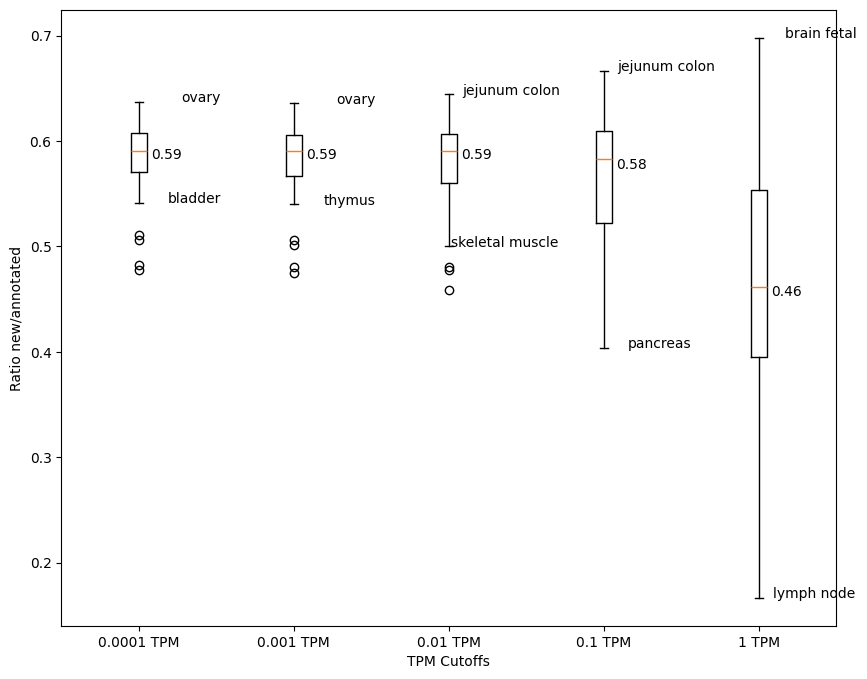

Outlier Names: ['brain', 'brain opioid', 'brain alzheimer', 'brain fetal', 'brain', 'brain opioid', 'brain alzheimer', 'brain fetal', 'brain', 'brain opioid', 'brain alzheimer']


In [336]:
import matplotlib.pyplot as plt
from outliers import smirnov_grubbs as grubbs
from scipy.stats import mannwhitneyu

# plot the ratio for each cutoff
data_dicts = [ratio_00001, ratio_0001, ratio_001, ratio_01, ratio_1]
custom_labels = ["0.0001 TPM", "0.001 TPM", "0.01 TPM", "0.1 TPM", "1 TPM"]
# Create a list to store labels for outliers
outlier_labels = []

    
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot boxplots for each dictionary
for i, data_dict in enumerate(data_dicts):
    values = list(data_dict.values())
    labels = list(data_dict.keys())
    boxplot = ax.boxplot(values, positions=[i + 1], labels=[custom_labels[i]], widths=0.1)

    # Highlight outliers with their names
    outliers = boxplot['fliers']
    for box_index, outlier in enumerate(outliers):
        y = outlier.get_ydata()
        for idx, val in enumerate(y):
            index = values.index(val)
            outlier_name = f'{labels[index]}'
            outlier_labels.append(labels[idx])
    
    whiskers = boxplot['whiskers']
    min_whisker = whiskers[0]
    max_whisker = whiskers[1]

    min_y = min_whisker.get_ydata()[1]
    index = values.index(min_y)
    min_whisker_name = f'{labels[index]}'
    ax.annotate(min_whisker_name, (i + 1, min_whisker.get_ydata()[1]), textcoords="offset points", xytext=(40, 0), ha='center')

    max_y = max_whisker.get_ydata()[1]
    index = values.index(max_y)
    max_whisker_name = f'{labels[index]}'
    ax.annotate(max_whisker_name, (i + 1, max_whisker.get_ydata()[1]), textcoords="offset points", xytext=(45, 0), ha='center')

    median_y = round(boxplot['medians'][0].get_ydata()[0], 2)
    ax.annotate(median_y, (i + 1, median_y), textcoords="offset points", xytext=(20, -5), ha='center')

# Set labels and title
ax.set_xlabel('TPM Cutoffs')
ax.set_ylabel('Ratio new/annotated')
# Display the plot
plt.savefig('ratios_of_new_transcripts_with_different_cutoffs.png', dpi=300)
plt.show()

# Print the names of outliers
print("Outlier Names:", outlier_labels)


# Plot the ratio of each tissue and sort the plot after number of smaples per tissues (Spearman)

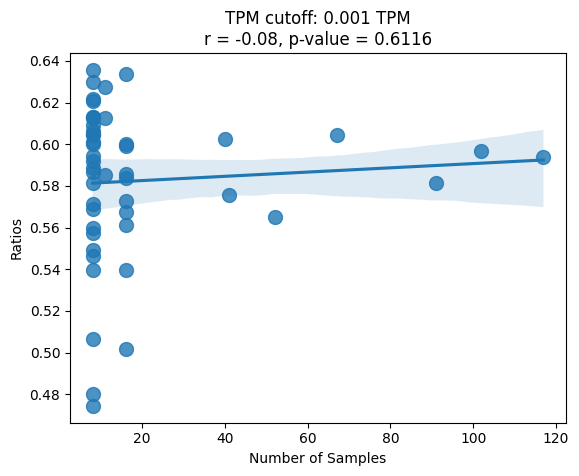

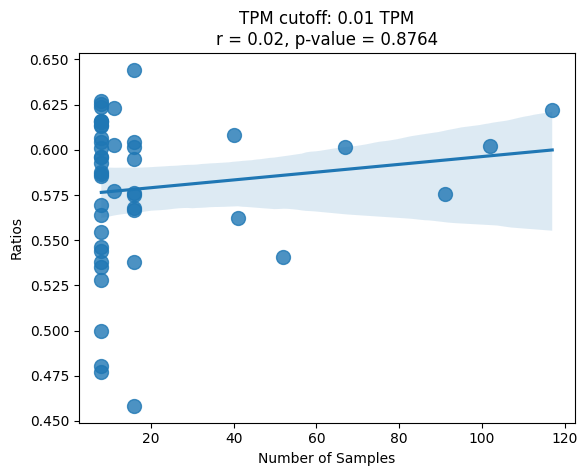

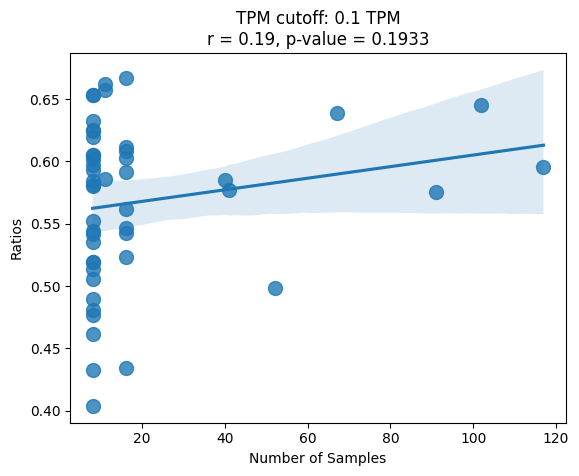

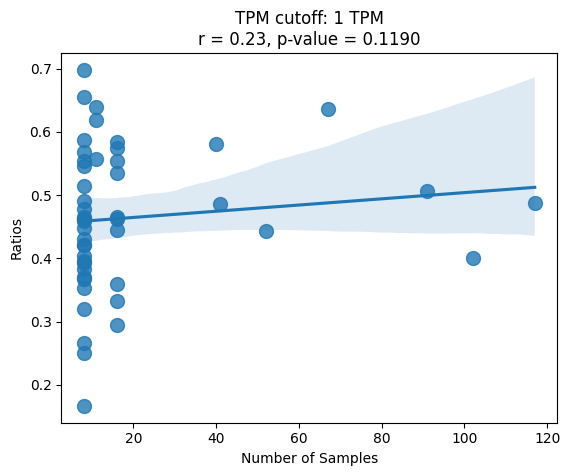

In [380]:
number_of_samples_per_tissue = pd.read_csv("Suppl_Table_S2_Tissues.csv", index_col=0)
number_of_samples_per_tissue = number_of_samples_per_tissue.rename(index={number_of_samples_per_tissue.index[0]: "brain"})# number_of
df_sorted = number_of_samples_per_tissue.sort_values(by='Number of Samples', ascending=False)
sorted_tissues_by_n = df_sorted.index.to_list()
sorted_tissues_by_n

tissue_list = df_sorted["Number of Samples"]

def spearman_(dict_ratios, sorted_tissues_by_n, cutoff):
    
    dict_sorted = {key: dict_ratios[key] for key in sorted_tissues_by_n}
    series = pd.Series(dict_sorted, name='Ratios')
    
    # Combine the two Series into a DataFrame
    df = pd.concat([tissue_list, series], axis=1)
    
    # Calculate the Spearman correlation coefficient and p-value
    spearman_corr, p_value = spearmanr(df['Number of Samples'], df['Ratios'])
    
    # Create a scatter plot with a regression line
    sns.regplot(x='Number of Samples', y='Ratios', data=df, scatter_kws={'s': 100})
    plt.title(f'TPM cutoff: {cutoff}\nr = {spearman_corr:.2f}, p-value = {p_value:.4f}')
    
    # Show the plot
    plt.savefig('correaltions_tissues_ratios_'+cutoff+'.png', dpi=300)

    plt.show()

# spearman_(ratio_00001, sorted_tissues_by_n)
spearman_(ratio_0001, sorted_tissues_by_n, "0.001 TPM")
spearman_(ratio_001, sorted_tissues_by_n,"0.01 TPM")
spearman_(ratio_01, sorted_tissues_by_n, "0.1 TPM")
spearman_(ratio_1, sorted_tissues_by_n, "1 TPM")

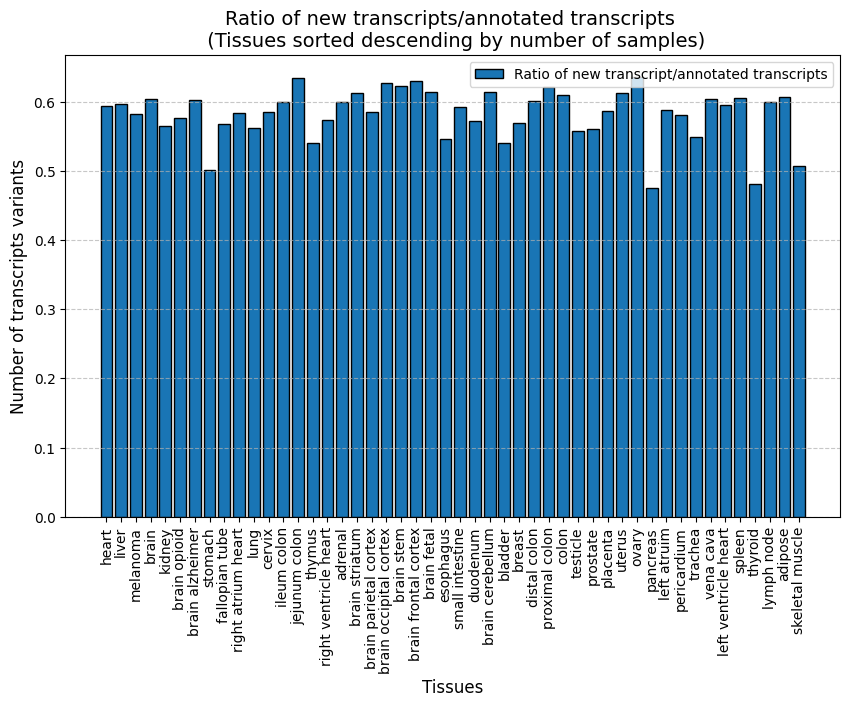

In [300]:
plot_tissues_sorted_with_ratio(ratio_0001, sorted_tissues_by_n)

In [298]:
def plot_tissues_sorted_with_ratio(dict, sorted_tissues_by_n):
    dict = {key.replace("TPM(mean)", ""): value for key, value in dict.items()}
    dict_sorted = {key: dict[key] for key in sorted_tissues_by_n}
    
    # Extract keys and values from the dictionary
    labels = list(dict_sorted.keys())
    values = list(dict_sorted.values())
    
    # Create a bar plot with additional styling
    plt.figure(figsize=(10, 6))  # Adjust the figure size
    
    # Create the bar plot
    bar_color = '#1975B5' 
    bar_color_NSTRG = '#B3C9F4'
    line_color = "red"
    
    # Create the bar plot
    plt.bar(labels, values, color=bar_color, edgecolor='black', label='Ratio of new transcript/annotated transcripts')
    # plt.bar(labels, values_NSTRG, color=bar_color_NSTRG, edgecolor='black', label='New transcript variants', alpha=0.7)
    
    # Rotate x-axis labels by -45 degrees and set font size
    plt.xticks(rotation=90, fontsize=10)
    
    # Add labels and title
    plt.xlabel('Tissues', fontsize=12)
    plt.ylabel('Number of transcripts variants', fontsize=12)
    plt.title('Ratio of new transcripts/annotated transcripts \n (Tissues sorted descending by number of samples)', fontsize=14)
    
    # Add grid lines
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value annotations on top of the bars
    # for label, value in zip(labels, values):
    #     plt.text(label, value + 0.1, str(value), ha='center', va='bottom', fontsize=8, color='black')
        
    # percentages = list(dict_percentage.values())
    # for label, value, number in zip(labels, values_NSTRG, percentages):
    #     plt.text(label, value + 1, f"{number}%", ha='center', va='top', fontsize=8, color='black', rotation=90)
    
    # Display the plot
    plt.legend()
    # plt.tight_layout(rect=(0.02, 0.02, 1, 1.02))
    plt.savefig('number_transcripts_per_tissue.png', dpi=300)
    plt.show()